In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

import lagrangian_optim as lgopt
from scipy import optimize as sp_optimize

### Generate data from Normal Means model

Sample $\mathbf{b}$ from a mixture of Gaussians, and sample $\mathbf{y}$ from the multivariate Gaussian $N_n(\mathbf{b}, \mathbb{I}_n)$, where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

$\mathbf{b} \sim \sum_{k = 1}^{K}w_k N(0, \sigma_k^2)$

$\mathbf{y} \sim N_n(\mathbf{b}, \mathbb{I}_n)$,

where $n$ is the number of samples.
The posterior probability $\hat{q}(\mathbf{b} \mid \mathbf{y}, w_1, \ldots, w_K, \sigma_1, \ldots, \sigma_K)$ is obtained analytically (using Eq. 26 and 27 of [this document](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521)).
We also calculate the posterior mean $\mathbf{b}^{*} \triangleq \mathbb{E}_{\hat{q}}[\mathbf{b}]$. 

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [9]:
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

p = 500
k = 4
sparsity = 0.8
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity, scale = 10.0)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
print ("Standard deviation of prior mixture components:")
print (sk)

dj = np.ones(p)
nmash = NormalMeansASHScaled(y, strue, wtrue, sk, d = dj)
qphi, qmu, qvar = nmash.posterior()

bpostmean = np.sum(qphi * qmu, axis = 1)
wpost = np.sum(qphi, axis = 0)
wpost = wpost / np.sum(wpost)

Standard deviation of prior mixture components:
[0.         0.77827941 2.16227766 4.62341325]
2022-03-11 13:46:27,863 | mrashpen.models.normal_means_ash_scaled | DEBUG | Calculating posterior for NM model.


In [10]:
bconst = bpostmean.copy()

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj)
theta_newraph = Minv.x
b_newraph = lgopt.shrink_theta(theta_newraph, strue, wpost, sk, dj)

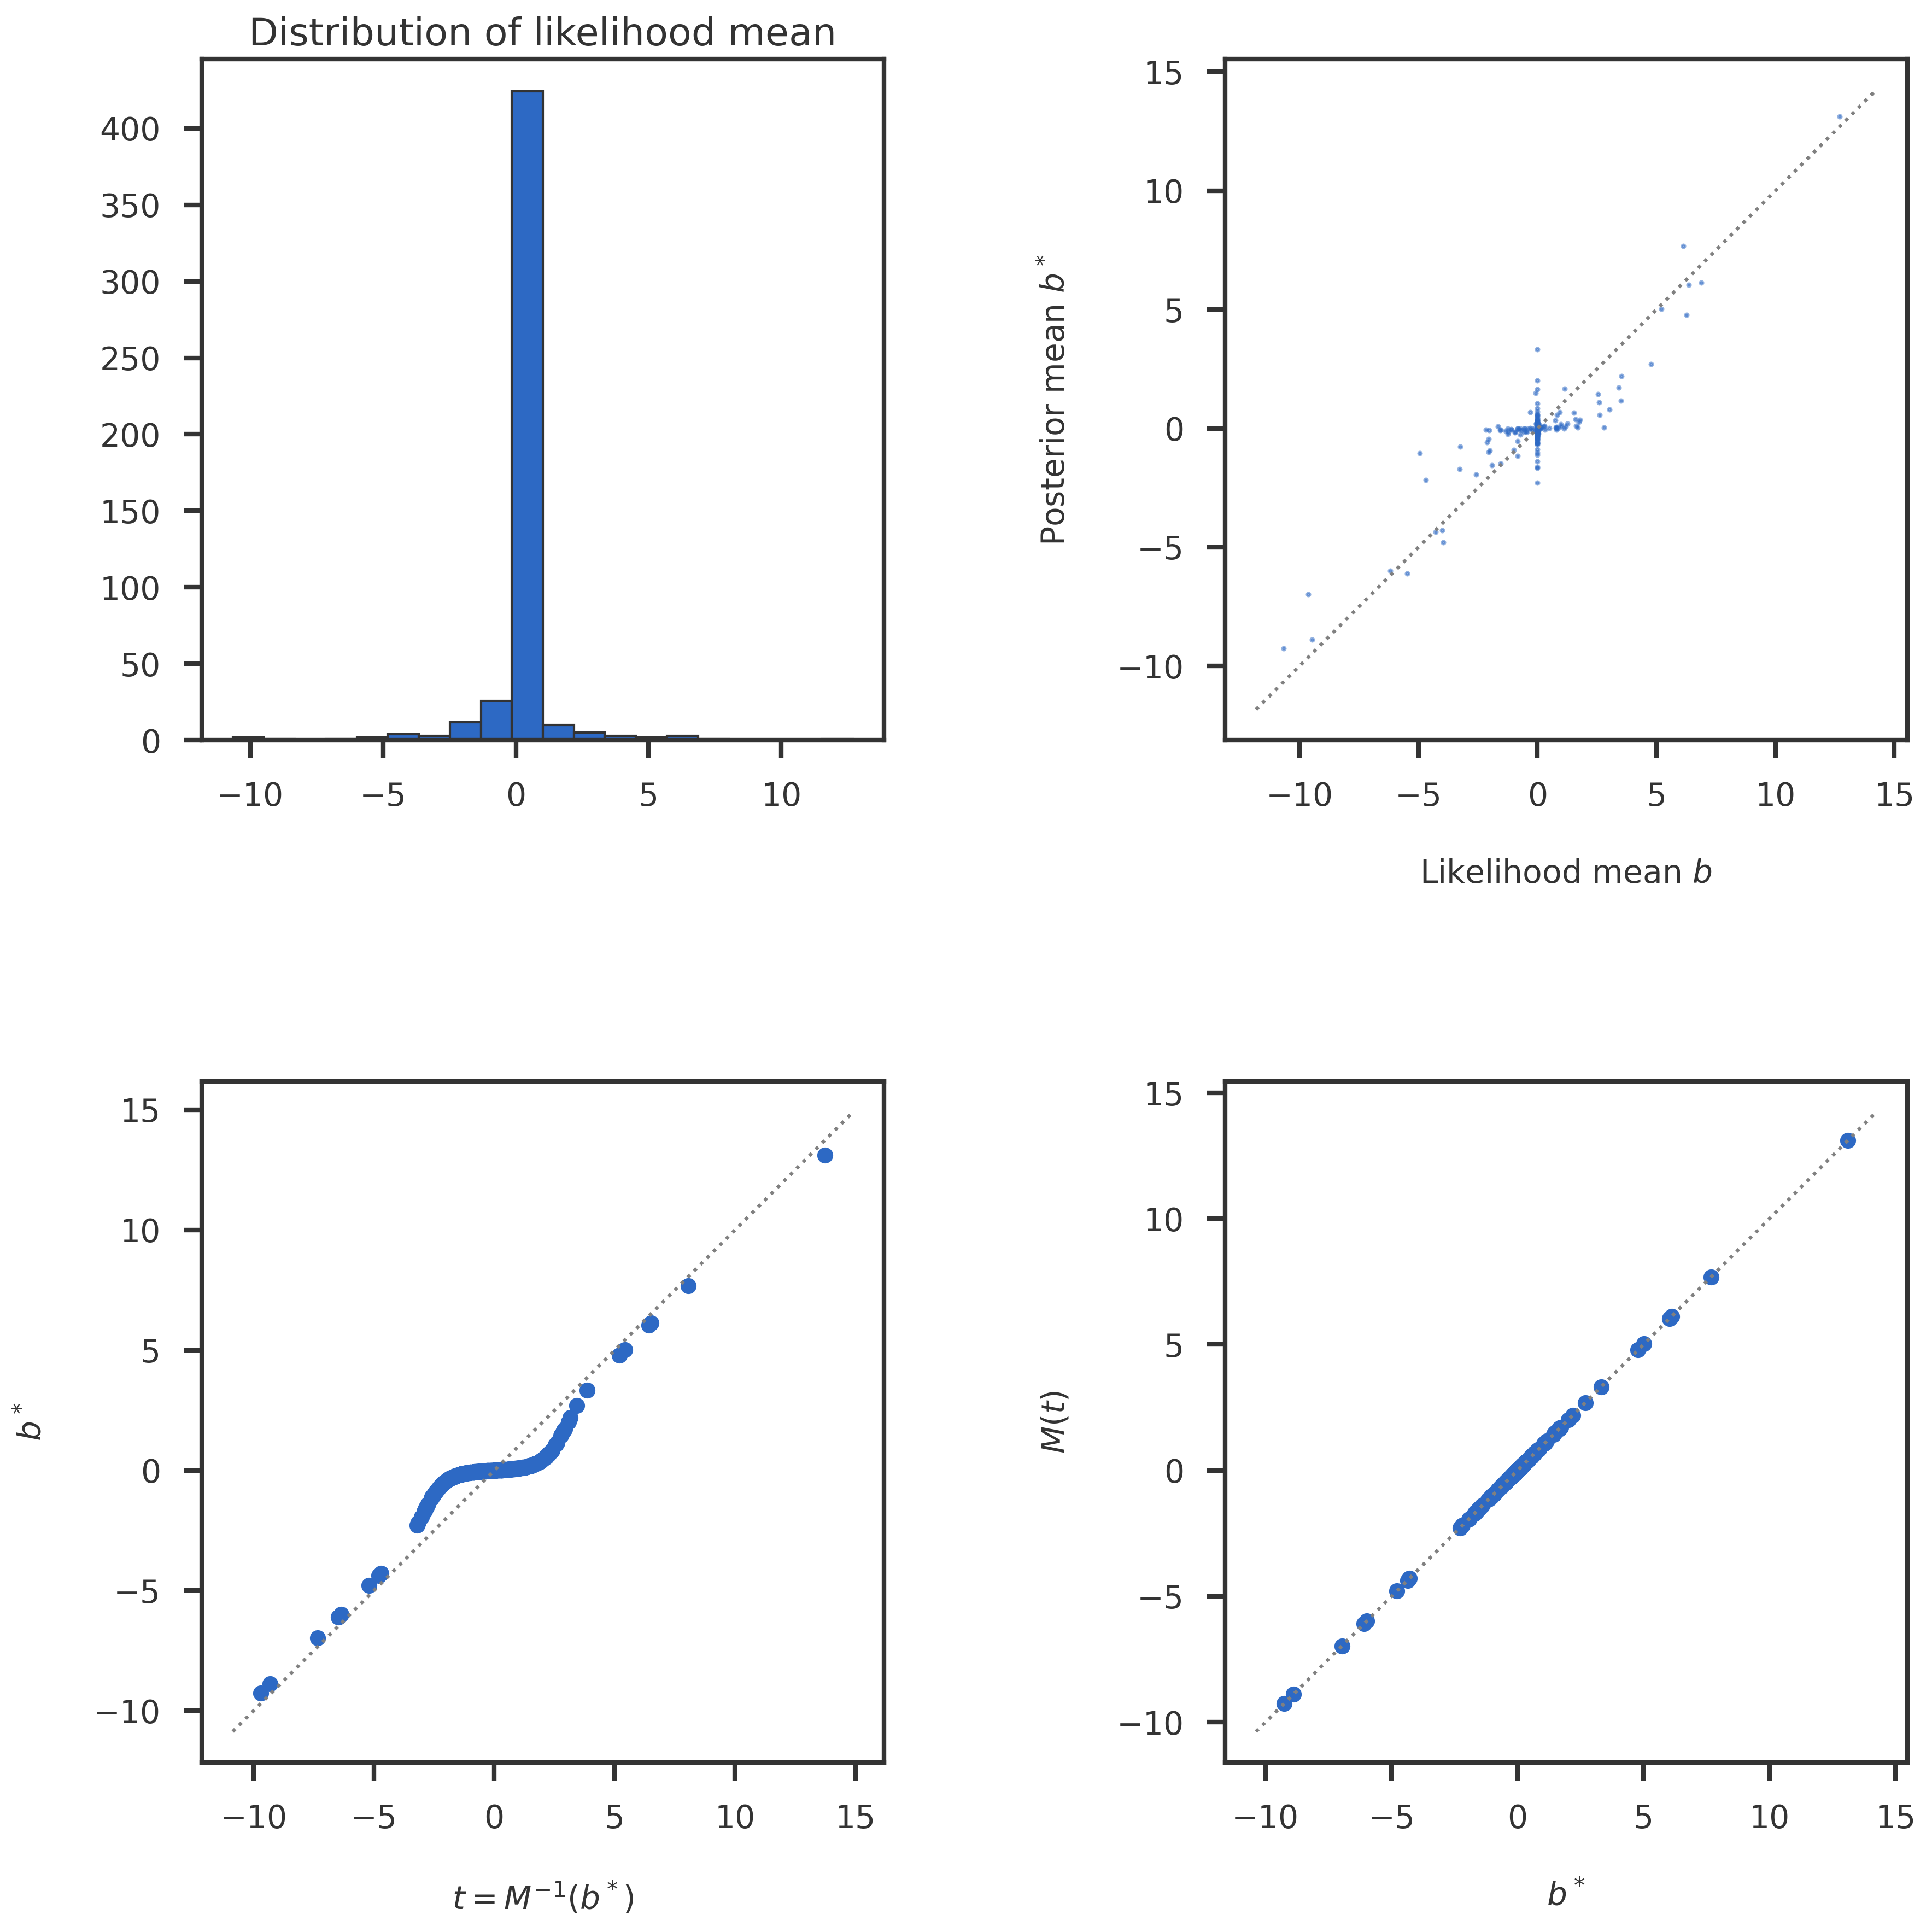

In [11]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.hist(btrue)
ax1.set_title("Distribution of likelihood mean")

ax2.scatter(btrue, bpostmean, s=2, alpha = 0.5)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"Likelihood mean $b$")
ax2.set_ylabel(r"Posterior mean $b^*$")
#ax1.hist(mean)

#ax3.scatter(bconst, theta_newraph)
ax3.scatter(theta_newraph, bconst)
mpl_utils.plot_diag(ax3)
ax3.set_ylabel(r"$b^*$")
ax3.set_xlabel(r"$t = M^{-1}(b^*)$")

ax4.scatter(bconst, b_newraph)
mpl_utils.plot_diag(ax4)
ax4.set_xlabel(r"$b^*$")
#ax4.set_ylabel(r"$M(M^{-1}(b^*))$")
ax4.set_ylabel(r"$M(t)$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

#### Prior mixture coefficients

In [12]:
wtrue

array([0.8       , 0.06666667, 0.06666667, 0.06666667])

#### Posterior mixture coefficients

In [13]:
wpost

array([0.79766979, 0.06806508, 0.06792859, 0.06633654])

### The derivatives of the Lagrangian function are not zero at optimum.

In [18]:
lgrng = np.ones(p)
dLdl, dLdw, dLdt = lgopt.penalty_operator_lagrangian_deriv(theta_newraph, wpost, strue, sk, dj, lgrng, bconst)

In [19]:
dLdt

array([-2.76811308e-01,  4.77369457e-02, -1.11786670e-01, -5.88292580e-02,
       -3.67761410e-03,  5.68755719e-02,  1.43188512e-01,  7.29370153e-02,
        9.77246493e-02,  5.26069368e-02,  5.17632940e-02,  3.22958637e-01,
       -5.52153364e-02,  2.75932244e-01,  2.14684175e-01,  1.54152445e+00,
        1.00942588e-01, -3.35288479e-02,  6.50607281e-02,  5.13572846e-02,
        8.87666022e-02,  1.19249704e-01,  6.01499037e-02,  2.15987566e-01,
        2.39580351e+00,  4.70793092e-01,  5.65723364e-02,  9.90003973e-01,
       -5.42321293e-02,  2.01228529e+00,  4.01758416e+00,  1.99343008e-01,
        2.41641486e-02,  7.34843431e-02,  1.62738386e-01, -3.93992049e-01,
        2.69764684e+00,  3.08036732e-01,  5.97381383e-01,  7.29445536e-02,
        5.94169409e-02,  7.98356457e-02,  1.57459036e-01, -3.26322544e-01,
        7.16906613e-02,  1.17675883e+00,  4.67757763e-02,  1.98218353e-02,
        3.61176597e-02,  2.04248263e-01, -7.43687186e-01,  4.29028531e+00,
        1.39125035e-01,  

### Minimization of penalty function

Here, we minimize the penalty function $\rho(M(\theta))$ with the constraint $M(\theta) = \hat{\mathbf{b}}$, given $\sigma_k$ and $\sigma^2 = 1$. We expect to obtain $\hat{q}$ from the minimization. 

In [20]:
thetainit = theta_newraph.copy()
softmax_base = np.exp(1)
winit     = wpost.copy()
#winit, _ = initialize_ash_prior(k, sparsity = 0.98)
akinit    = np.log(winit) / np.log(softmax_base)
winit     = lgopt.softmax(akinit, base = softmax_base)
lgrng     = np.ones(p) * 1.0

initparams = np.concatenate([thetainit, lgrng, akinit])
cg_min = sp_optimize.minimize(lgopt.objective_numeric_lagrangian, 
                              initparams,
                              args = (strue, sk, dj, bpostmean, p, k, softmax_base),
                              method = 'CG',
                              options = {'disp': True, 'maxiter': 100, 'return_all': True}
                             )

         Current function value: 5.227606
         Iterations: 100
         Function evaluations: 220095
         Gradient evaluations: 219


Est. w:  0.901, 0.000, 0.099, 0.000
Est. Lagrangian (for non-zero b): 
[ 1.14571519  0.98716634  0.9995002  -1.60424401  0.97429661  0.99122944
  0.96630311  0.99401024  1.36907177  0.54419838  0.93538815  0.9305848
  1.59167029  0.55273037  1.75402866  0.51094143  0.99275688  0.99200083
  1.01312337  1.09194378  1.02155461  0.9774995   1.89378645  0.9753254
  1.01089784  1.30446765  1.12799437  1.02379075  0.99736889  1.00723157
  1.63839336  0.98652306  0.9183767   1.01055846  1.96537844  0.94726225
  1.09955997  0.98386386 -1.31003583  0.90657087  0.97159517  0.98238974
  0.9096598   1.13391523 -1.0750713   1.36920598  1.24563505 -1.29244428
  1.74447034  0.99380116  1.01497744  0.79969392  0.80452576  0.99715346
  0.52895103  0.95784672  0.94005983  1.47014411  1.02189357 -1.67575533
  0.68735771  1.05034449 -0.61495556  0.92157868  1.0223817   1.78416168
  1.09144789  0.99624462  0.60920248  1.69021939  1.6996074   1.66531312
  1.02290762  1.49126608  0.80617373  0.81932034  0.474

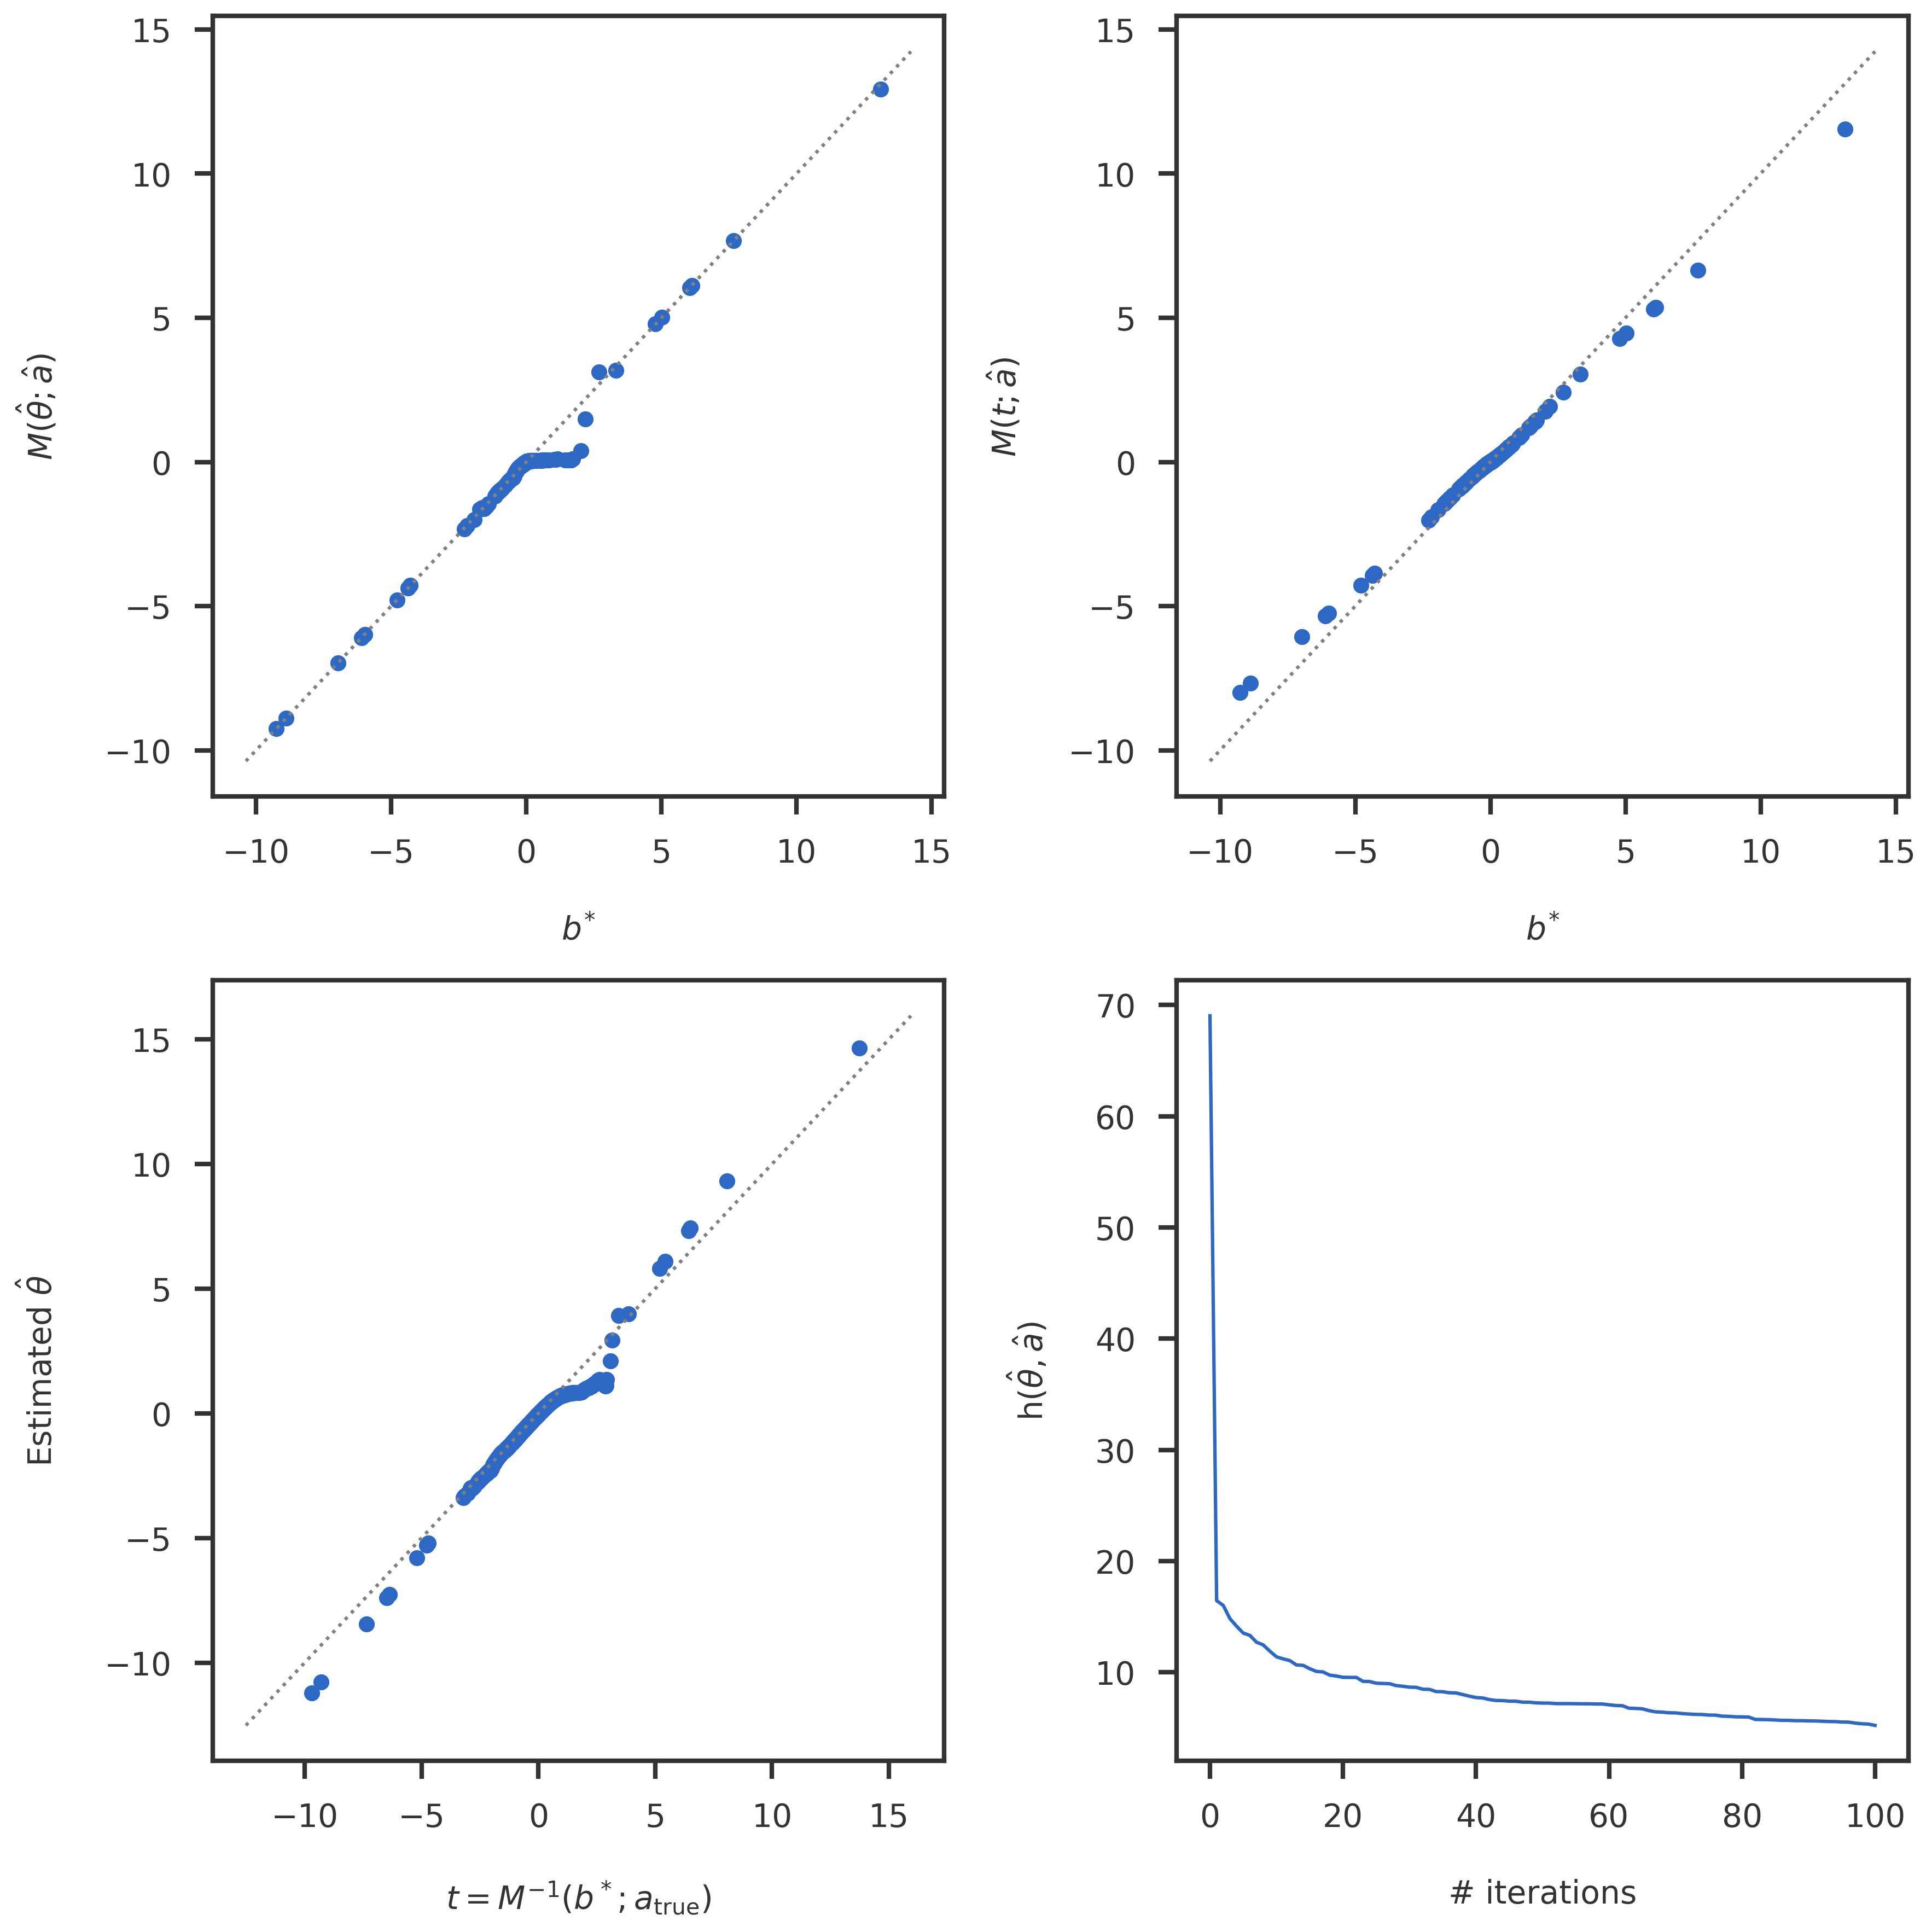

In [21]:
theta_cg = cg_min.x[:p]
a_cg = cg_min.x[2*p:]
w_cg = lgopt.softmax(a_cg, base = softmax_base)
lj_cg = cg_min.x[p:2*p]
#print ("True w:", wtrue)
print("Est. w: ", ', '.join([f"{x:.3f}" for x in w_cg]))
print("Est. Lagrangian (for non-zero b): ")
print(lj_cg[btrue!=0])

b_cg = lgopt.shrink_theta(theta_cg, strue, w_cg, sk, dj)
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(bconst, b_cg)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel(r"$b^{*}$")
ax1.set_ylabel(r"$M(\hat{\theta}; \hat{a})$")

b_cg_gpost = lgopt.shrink_theta(theta_newraph, strue, w_cg, sk, dj)
ax2.scatter(bconst, b_cg_gpost)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"$b^{*}$")
ax2.set_ylabel(r"$M(t; \hat{a})$")

ax3.scatter(theta_newraph, theta_cg)
mpl_utils.plot_diag(ax3)
ax3.set_xlabel(r'''$t = M^{-1}(b^*; a_{\mathrm{true}})$''')
ax3.set_ylabel(r'''Estimated $\hat{\theta}$''')

niter   = cg_min.nit
allobjs = np.zeros(niter + 1)
for i, params in enumerate(cg_min.allvecs):
    z_it = params[:p]
    a_it = params[2*p:]
    lj_it = params[p:2*p]
    w_it = lgopt.softmax(a_it, base = softmax_base)
    #alllagrangian[i] = penalty_operator_lagrangian(z_it, w_it, strue, sk, dj, lj_it, btrue)
    allobjs[i] = lgopt.objective_numeric_lagrangian(params, strue, sk, dj, bpostmean, 
                                                               p, k, softmax_base)
ax4.plot(np.arange(niter + 1), allobjs)
ax4.set_xlabel("# iterations")
ax4.set_ylabel(r"h($\hat{\theta}, \hat{a}$)")

plt.tight_layout()
plt.show()

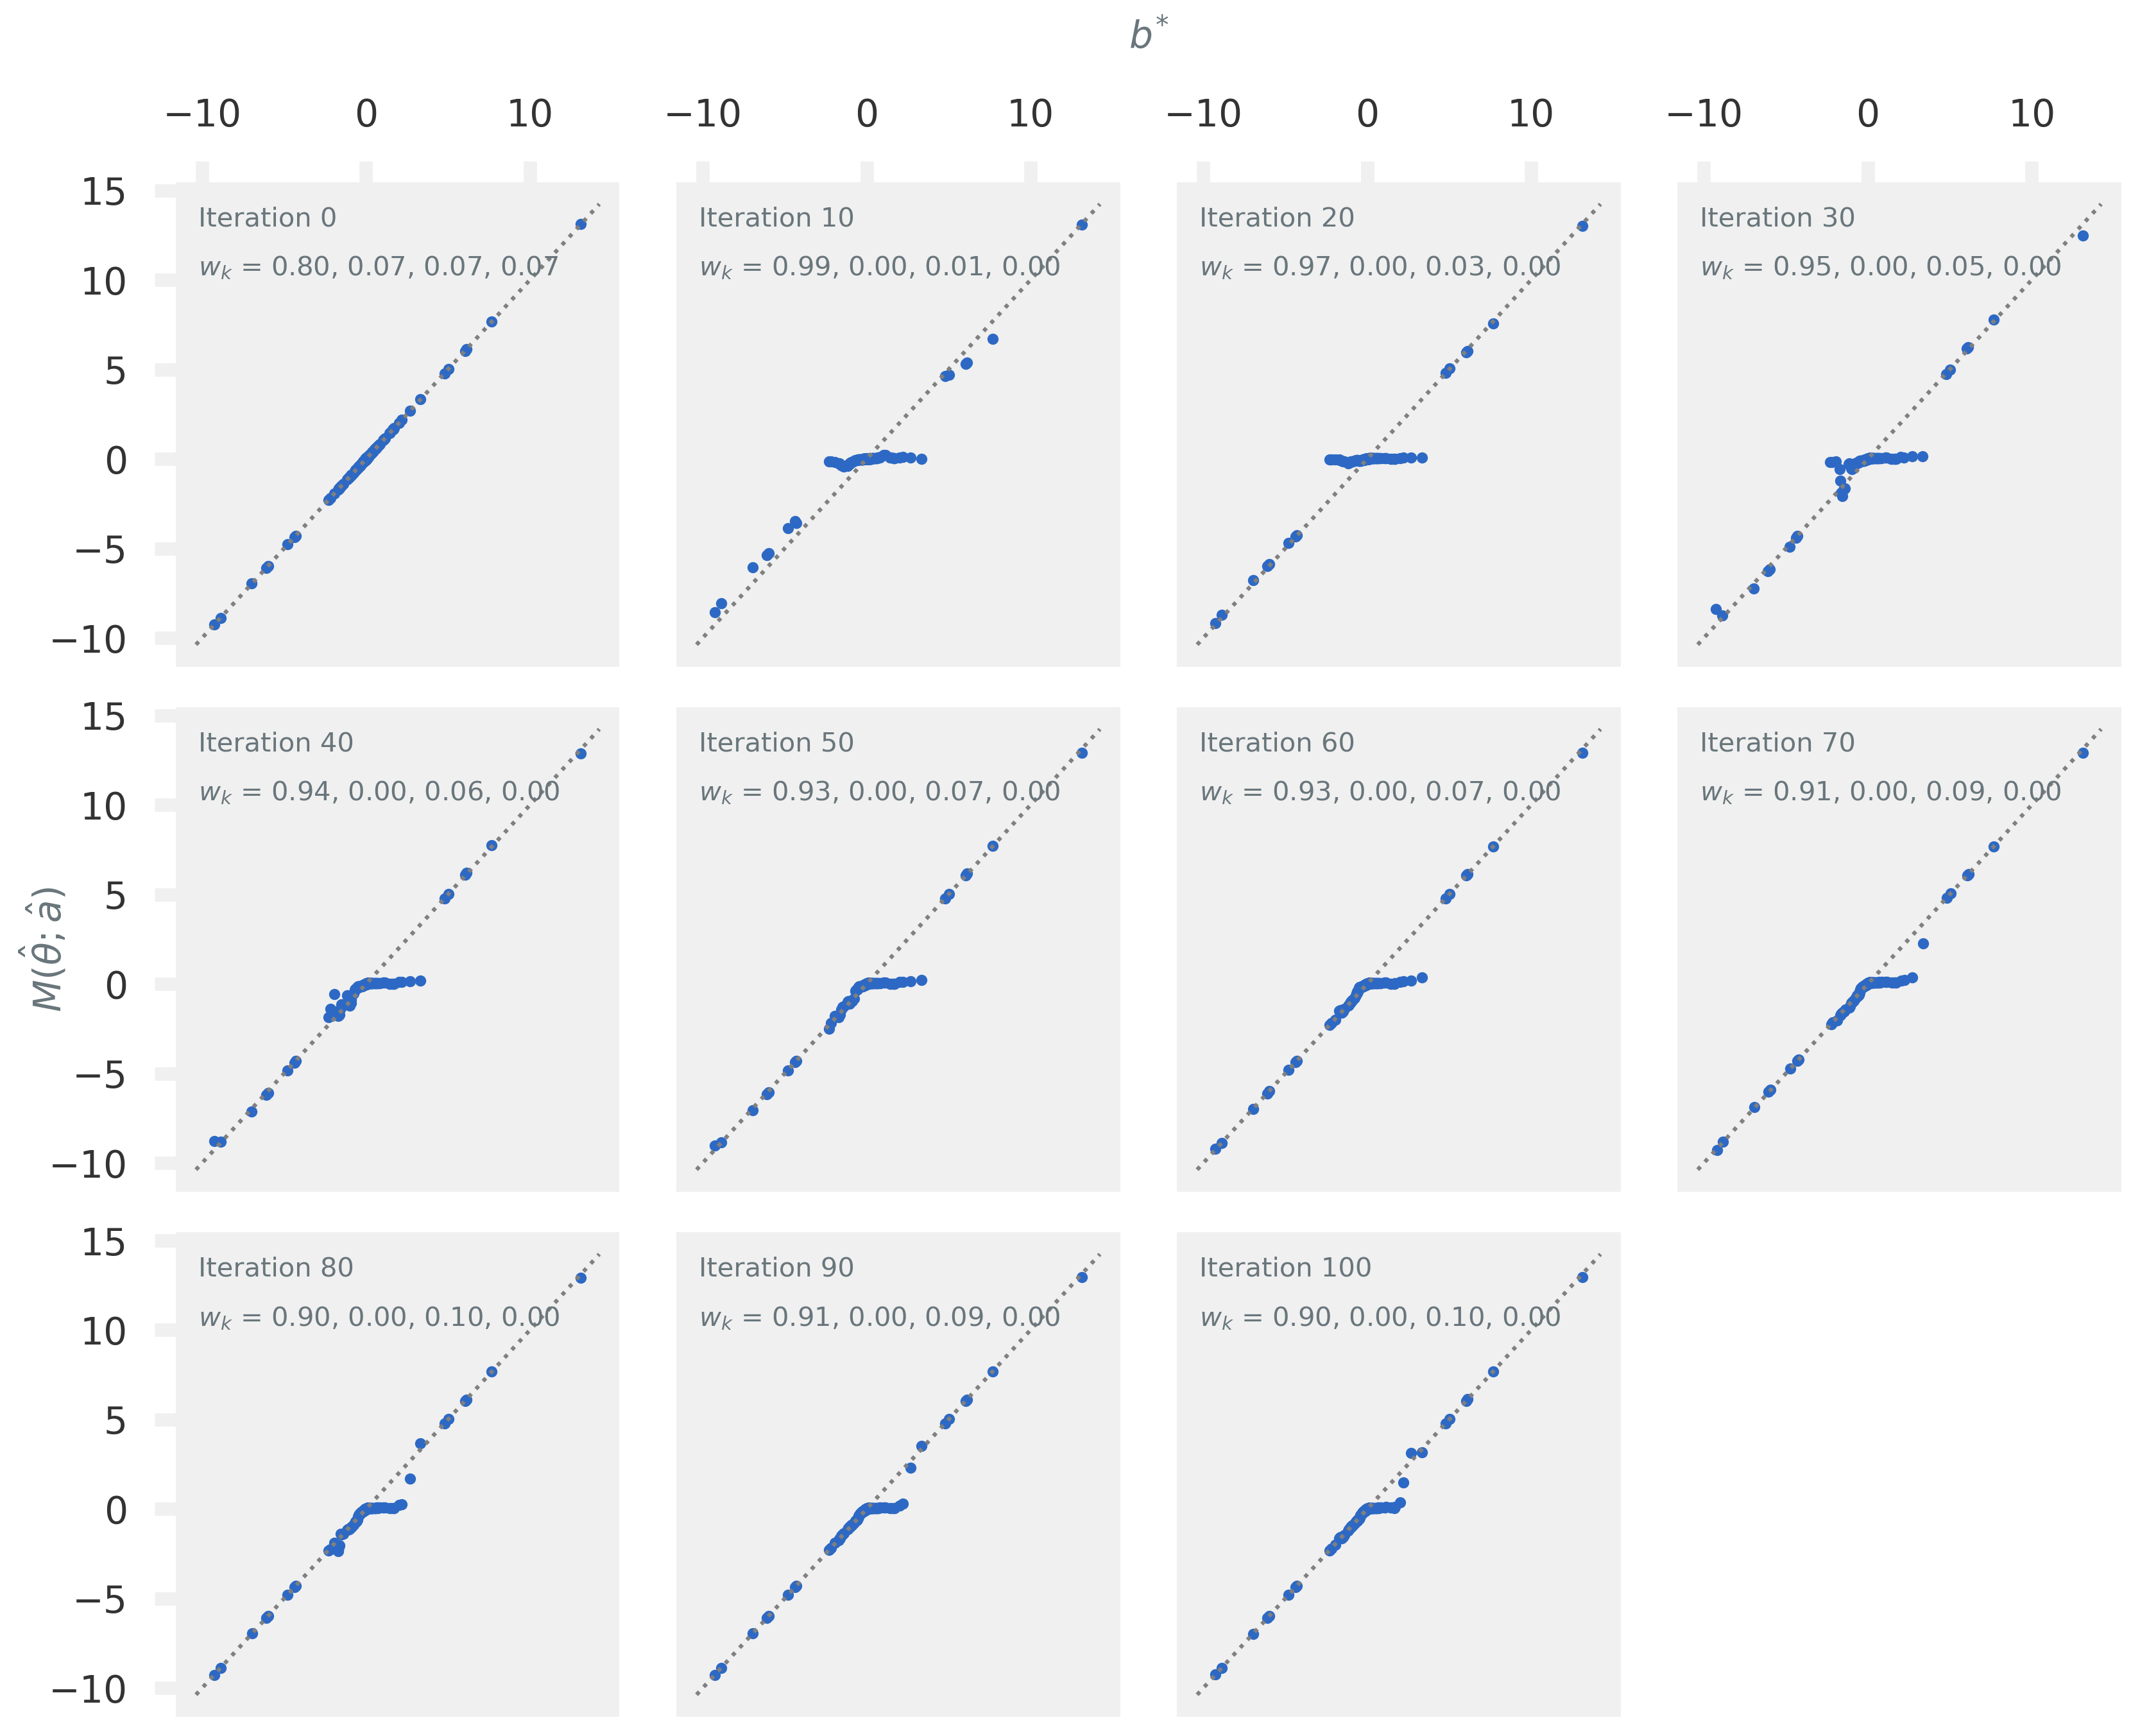

In [22]:
subplot_h = 1.8
nstep = 10
nplot = int(niter / nstep) + 1
ncol  = 4
nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
figw  = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh  = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
figscale = 12.0 / figw

bgcolor = '#F0F0F0'
highlight_color = '#EE6868'
subdue_color = '#848f94'
text_color = '#69767c'

fig = plt.figure(figsize = (figw * figscale, figh * figscale))
axmain = fig.add_subplot(111)

for i in range(nplot):
    ax  = fig.add_subplot(nrow, ncol, i + 1)
    itr = i * nstep
    
    params = cg_min.allvecs[itr]
    z_it = params[:p]
    a_it = params[2*p:]
    #lj_it = params[p:2*p]
    w_it = lgopt.softmax(a_it, base = softmax_base)
    b_it = lgopt.shrink_theta(z_it, strue, w_it, sk, dj)
    
    ax.scatter(bconst, b_it, s=10)
    mpl_utils.plot_diag(ax)
    
    wtext = r'$w_k$ = ' + ', '.join([f"{w:.2f}" for w in w_it])
    itrtext = f"Iteration {itr}"
    
    ax.text(0.05, 0.85, wtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.text(0.05, 0.95, itrtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        #ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    #ax.set_ylim(-0.1, 2.1)
    
axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.set_ylabel(r"$M(\hat{\theta}; \hat{a})$", labelpad = 40, color = text_color)
axmain.set_xlabel(r'$b^{*}$', labelpad = 50, color = text_color)
axmain.xaxis.set_label_position('top') 


plt.tight_layout()
# plt.savefig(f'../plots/{fileprefix}.pdf', bbox_inches='tight')
# plt.savefig(f'../plots/{fileprefix}.png', bbox_inches='tight')
plt.show()